In [1]:
# Author: Antti Kiviaho
# Date: 4.11.2022
#
# This notebook is for creating synthetic spatial data to be used as ground truth in the SPATAC
# (SPAtial ATAC) project. It follow the structure presented in cell2location toolkit supplementaries:
# https://github.com/vitkl/cell2location_paper/blob/master/notebooks/benchmarking/synthetic_data_construction_improved_real_mg.ipynb
#
# This notebook requires conda env 'pymc' to be active
#
# Previously trained cell2location model has been downloaded from:
# https://drive.google.com/drive/folders/1UfMe_uTS2yV9ErQA_iGBa4oCDYlFhtWN?usp=sharing



In [3]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'

import pymc as pm

import cell2location.models as c2l
import cell2location.plt as c2lpl
import cell2location.cluster_averages 
import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

import itertools

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

os.chdir('/lustre/scratch/kiviaho/spatac/')
date = 20221104
sp_data_folder ='synthetic-spatial/'

In [90]:
# Note: There are 3 times less clusters and less cells in the SHARE-seq dataset. This must be considered

## simulation settings
seed = 55221 # changed from 253286
n_locations = [50, 50] # 50*50 grid
n_experiments = 1 # Changed from 10

# sparsity and tissue zones
n_tissue_zones = 3 # Changed from 12
n_uniform = 0 # Changed from 8

# low and high density cell types
p_high_density = 0.3 # Changed from 0.2, 
mu_low_density = 1.0
mu_high_density = 2.8

In [3]:
# READ Visium in adata_vis
# Reading the data in
adata_vis = ad.read('data/spatial/cell2location/cell2location_multiexperiment_model_for_synthetic_data/sp.h5ad')
# Change gene index to SYMBOL for matching further down the line
adata_vis.var['ENSEMBL'] = adata_vis.var.index
symbol_index = pd.Index(adata_vis.var['SYMBOL'],dtype='str')
adata_vis.var.index = symbol_index
adata_vis.var.index = adata_vis.var.index.rename('Gene')

In [ ]:
# # Load SHARE-seq data
# rna = ad.read_h5ad('data/share-seq/mouse-brain/share-seq-mouse-brain-rna-data.h5ad')
# atac = ad.read_h5ad('data/share-seq/mouse-brain/share-seq-mouse-brain-atac-data.h5ad')

# # Filter out unannotated & no ATAC data containing cells:
# rna = rna[rna.obs['Barcode'].isin(atac.obs['rna.bc'])]
# merged_obs = pd.merge(rna.obs['Barcode'],atac.obs,how='inner',left_on='Barcode',right_on='rna.bc')
# merged_obs.index = pd.Index(merged_obs.index,dtype='str')
# if all(rna.obs['Barcode'].reset_index(drop=True) == merged_obs['Barcode'].reset_index(drop=True)):
#     rna.obs = merged_obs

# rna.var_names = rna.var['Gene']
# del atac


In [37]:
# cells_to_keep = ['EN','IN','A1.E1','OG1']
# cell_idxs = np.where(rna.obs['celltype'].str.contains('|'.join(cells_to_keep)))[0]
# rna = rna[cell_idxs]
# aggr_celltypes = rna.obs['celltype'].astype(str)
# aggr_celltypes[aggr_celltypes.str.contains('EN')] = 'EN'
# aggr_celltypes[aggr_celltypes.str.contains('IN')] = 'IN'
# rna.obs['broad_celltype'] = aggr_celltypes


# c2l_marker_genes_dict = {'Excitatory|Claustrum':['Nr4a2','Synpr'],
#                          'Excitatory|Amygdala':['Lypd1','Kcng1','C1ql3'],
#                          'Excitatory|hippocampus CA1':['Rprml','Wipf3','Neurod6'],
#                          'Excitatory|hippocampus CA3':['Nr4a3','Nptx1','Rnf182'],
#                          'Excitatory|thalamus':['Synpo2','Ptpn3','Slc17a6'],
#                          'Excitatory|hypothalamus':['Prkch','Ramp3','Shox2'],
#                          'Excitatory|cortex':['Sox5','Htr2c','Kcnk2','Dkk3','Rorb','Foxp3','Bcl11b','Cux2','Thsd7a','Cux1'],
#                          'Inhibitory|habenula':['Nwd2','Lrrc55','Syt9'],
#                          'Inhibitory|cortex/hippocampus':['Pvalb','Vip','Lamp5','Dlx6os1','Kcnip1','Sst','Vwc2'],
#                          'Inhibitory|striatum':['Drd1','Rgs9','Nexn'],
#                          'Inhibitory|thalamus':['Esrrg','Nova1','Scg2','Fign','Syt2','Tmem130'],
#                          'Microglia':['Ptprc'],
#                          'Neuroblasts':['Sox2','Dcx','Pax6'],
#                          'Oligodendrocytes':['Mog','Cnksr3','Plp1'],
#                          'OPCs':['Bmp4','Pdgfra'],
#                          'Astrocytes':['Aldoc','Slc1a3','Hepacam']}
# sc.pl.dotplot(rna,c2l_marker_genes_dict,groupby=['broad_celltype'],dendrogram=True,figsize=(12,6),standard_scale='var')


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gene_level_alpha_hyp, gene_level_beta_hyp]
INFO:pymc:NUTS: [gene_level_alpha_hyp, gene_level_beta_hyp]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


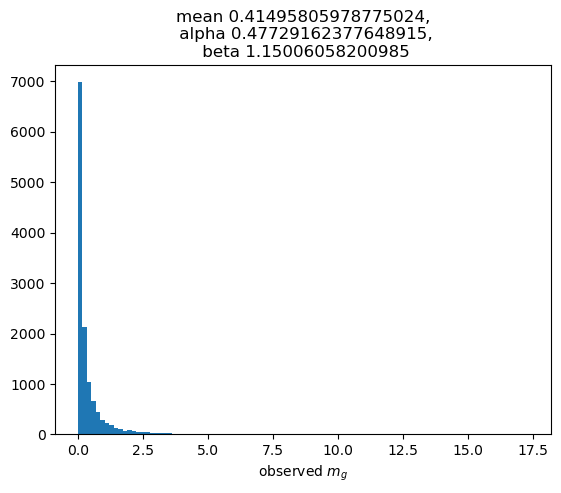

In [61]:
# put observed gene levels to data frame
gene_level_df = pd.DataFrame(adata_vis.uns['mod']['post_sample_means']['m_g'].T,
                          index=adata_vis.var.index,
                          columns=['gene_level'])

with pm.Model() as model:
    gene_level_alpha_hyp = pm.Gamma('gene_level_alpha_hyp', 1, 1, shape=(1, 1))
    gene_level_beta_hyp = pm.Gamma('gene_level_beta_hyp', 1, 1, shape=(1, 1))
    # global gene levels
    gene_level = pm.Gamma('gene_level', gene_level_alpha_hyp,
                          gene_level_beta_hyp, shape=(gene_level_df.shape[0], 1),
                          observed=gene_level_df.values)
    
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)
    

plt.hist(gene_level_df.values.flatten(), bins=100);
plt.xlabel(r'observed $m_g$')
plt.title(f'mean {gene_level_df.values.mean()},\n alpha {posterior.posterior.gene_level_alpha_hyp.mean()},\n beta {posterior.posterior.gene_level_beta_hyp.mean()}');


In [91]:
## simulation settings
np.random.seed(seed)

## generate per cell type simulation attributes
n_cell_types = rna.obs['broad_celltype'].value_counts().shape[0]
n_sparse = n_cell_types - n_uniform
n_zones_per_cell_type = np.random.binomial(n_tissue_zones, 0.02, size=n_sparse)+1
experiment_id = np.repeat(np.arange(n_experiments), np.prod(n_locations))
cell_types = np.array(rna.obs['broad_celltype'].unique())
uniform_cell_types = np.random.choice(cell_types, n_uniform, replace=False)
sparse_cell_types = cell_types[~np.isin(cell_types, uniform_cell_types)]

# generate matrix of which cell types are in which zones
cell_types2zones = pd.DataFrame(0, index=cell_types, 
                                columns=[f'tissue_zone_{i}' for i in range(n_tissue_zones)] \
                                + [f'uniform_{i}' for i in range(n_uniform)])
for i, n in enumerate(n_zones_per_cell_type):
    pos = np.random.randint(n_tissue_zones, size=n)
    cell_types2zones.iloc[i,pos] = 1
    
# and which uniform cell types belong to which uniform pattern
for i in range(n_uniform):
    cell_types2zones.iloc[n_sparse+i, n_tissue_zones+i] = 1
    
cell_types2zones.sum(), cell_types2zones.sum(1)

(tissue_zone_0    2
 tissue_zone_1    1
 tissue_zone_2    1
 dtype: int64,
 EN       1
 IN       1
 OG1      1
 A1.E1    1
 dtype: int64)

In [72]:
np.random.seed(seed)
# Assign cell types to either high or low density, balanced by uniform / tissue zone
high_density_cell_types = list(np.random.choice(uniform_cell_types, 
                                                int(np.round(n_uniform * p_high_density)), 
                                                replace=False))
for z, n in cell_types2zones.sum().items():
    
    ct = list(np.random.choice(cell_types2zones.index[cell_types2zones[z] > 0], 
                                                int(np.round(n * p_high_density)), 
                                                replace=False))
    print(ct)
    high_density_cell_types = high_density_cell_types + ct
    
low_density_cell_types = cell_types[~np.isin(cell_types, high_density_cell_types)]
    
# what proportion of cells are uniform?
len(high_density_cell_types) / len(cell_types)

['OG1']
[]
[]


0.25

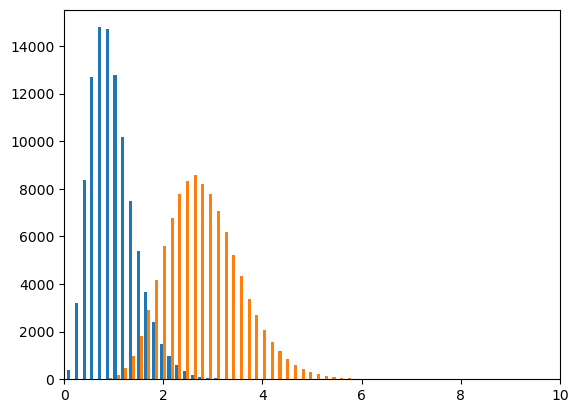

In [73]:
np.random.seed(seed)
#Generate average abundance for low and high density cell types
mean_var_ratio = 5
plt.hist([np.random.gamma(mu_low_density * mean_var_ratio, 1/mean_var_ratio, size=int(1e5)),
          np.random.gamma(mu_high_density * mean_var_ratio, 1/mean_var_ratio, size=int(1e5))], bins=50);
plt.xlim(0, 10);

cell_types2zones.loc[low_density_cell_types] = cell_types2zones.loc[low_density_cell_types] \
 * np.random.gamma(mu_low_density * mean_var_ratio, 
                   1/mean_var_ratio, 
                   size=(len(low_density_cell_types), 1))

cell_types2zones.loc[high_density_cell_types] = cell_types2zones.loc[high_density_cell_types] \
 * np.random.gamma(mu_high_density * mean_var_ratio, 
                   1/mean_var_ratio, 
                   size=(len(high_density_cell_types), 1))

In [67]:
cell_types2zones

,tissue_zone_0,tissue_zone_1,tissue_zone_2
EN,1.089940,0,0.00000
IN,3.294736,0,0.00000
OG1,0.677649,0,0.00000
A1.E1,0.000000,0,0.37994


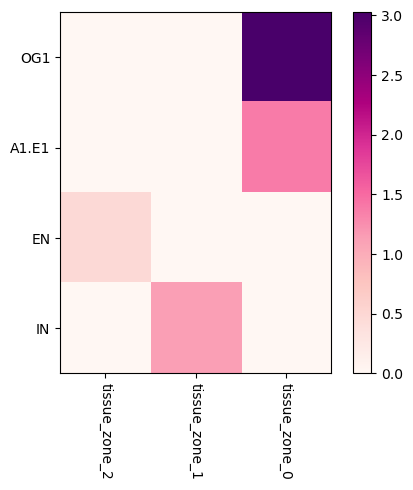

In [75]:
from cell2location.plt.plot_heatmap import clustermap
clustermap(cell_types2zones, figure_size=[5, 5])

In [76]:
def kernel(X1, X2, l=1.0, eta=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return eta**2 * np.exp(-0.5 / l**2 * sqdist)
    
def generate_grid(
              n=[50, 50] #spatial dimensions 
):
    n1, n2 = n 
    x1 = np.linspace(0, 100, n1)[:,None] #saptial dimensions 
    x2 = np.linspace(0, 100, n2)[:,None] #saptial dimensions 

    # make cartesian grid out of each dimension x1 and x2
    
    return pm.math.cartesian(x1[:,None], x2[:,None]), x1, x2

def random_GP(X, x1=1, x2=1, #coordinates
              n_variables = 5, #zones
              eta_true = 5, #variance, defines overlapping
              l1_true=[8, 10, 15], #bw parameter
              l2_true=[8, 10, 15]
             ):

    #cov1, cov2 = kernel(x1, x1, l=l1_true), kernel(x2, x2, l=l2_true)
    K = [np.kron(kernel(x1, x1, l=l1_true[i], eta=eta_true), 
                 kernel(x2, x2, l=l2_true[i], eta=eta_true)) 
         for i in range(n_variables)]

    gaus_true = np.stack([np.random.multivariate_normal(np.zeros(X.shape[0]), 
                                                        2*K[i]) 
                          for i in range(n_variables)]).T #samples from GP
    N_true = (np.exp(gaus_true).T / np.exp(gaus_true).sum(axis=1)).T #softmax transform 
    return N_true


def plot_spatial(values, n=[50,50], nrows=5, names=['cell type'],
                 vmin=0, vmax=1):
    
    n_cell_types = values.shape[1]
    n1, n2 = n 
    ncols = int(np.ceil((n_cell_types+1) / nrows))
    for ct in range(n_cell_types):
        plt.subplot(nrows, ncols, ct+1)
        plt.imshow(values[:,ct].reshape(n1,n2).T, 
                   cmap=plt.cm.get_cmap('magma'),
                   vmin=vmin, vmax=vmax
                  )
        plt.colorbar()
        if len(names) > 1:
            plt.title(names[ct])
        else:
            plt.title(f'{names[0]} {ct+1}')

    plt.subplot(nrows, ncols, n_cell_types+1) 
    plt.imshow(values.sum(axis=1).reshape(n1,n2).T, 
               cmap=plt.cm.get_cmap('Greys'))
    plt.colorbar()
    plt.title('total')

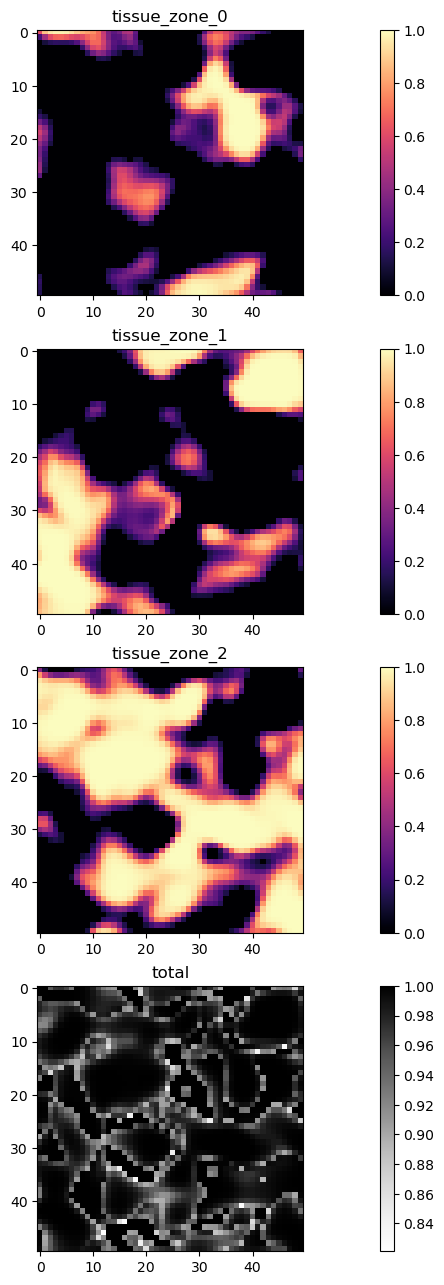

In [94]:
np.random.seed(seed)
# Sample bw parameter
mean_var_ratio = 1.2
mean = 8
tissue_zones_l1_true = np.random.gamma(mean * mean_var_ratio, 1 / mean_var_ratio, 
                                       size=(n_tissue_zones))
uniform_cell_types_l1_true = np.random.gamma(mean * mean_var_ratio, 1 / mean_var_ratio, 
                                             size=(len(uniform_cell_types)))
def sample_GP(locations, x1, x2):
    # Sample abundances with GP
    sparse_abundances = random_GP(X=locations, x1=x1, x2=x2, n_variables=n_tissue_zones, 
                                                    eta_true=1.5,
                                                    l1_true=tissue_zones_l1_true,
                                                    l2_true=tissue_zones_l1_true)
    sparse_abundances = sparse_abundances / sparse_abundances.max(0)
    sparse_abundances[sparse_abundances < 0.1] = 0

    if len(uniform_cell_types!=0):
        uniform_abundances = random_GP(X=locations, x1=x1, x2=x2, n_variables=len(uniform_cell_types), 
                                                          eta_true=0.5,
                                                        l1_true=uniform_cell_types_l1_true,
                                                        l2_true=uniform_cell_types_l1_true)
        uniform_abundances = uniform_abundances / uniform_abundances.max(0)
        uniform_abundances[uniform_abundances < 0.1] = 0

        abundances = np.concatenate([sparse_abundances, uniform_abundances], axis=1)
    else:
        abundances = sparse_abundances
    
    return pd.DataFrame(abundances, 
                                 index=[f'location_{i}' for i in range(abundances.shape[0])],
                                 columns=cell_types2zones.columns
                                )

locations_1, x1, x2 = generate_grid(n=n_locations)
locations = np.concatenate([locations_1 for _ in range(n_experiments)], axis=0)

abundances_df = pd.DataFrame()

for e in range(n_experiments):
    
    abundances_df_1 = sample_GP(locations_1, x1, x2)
    abundances_df_1.index = [f'exper{e}_{l}' for l in abundances_df_1.index]
    abundances_df = pd.concat((abundances_df, abundances_df_1), axis=0)
    
    plt.figure(figsize=(3*5+5,3*5+5))
    plot_spatial(abundances_df_1.values, n=n_locations, nrows=5, names=abundances_df.columns)
    plt.show()

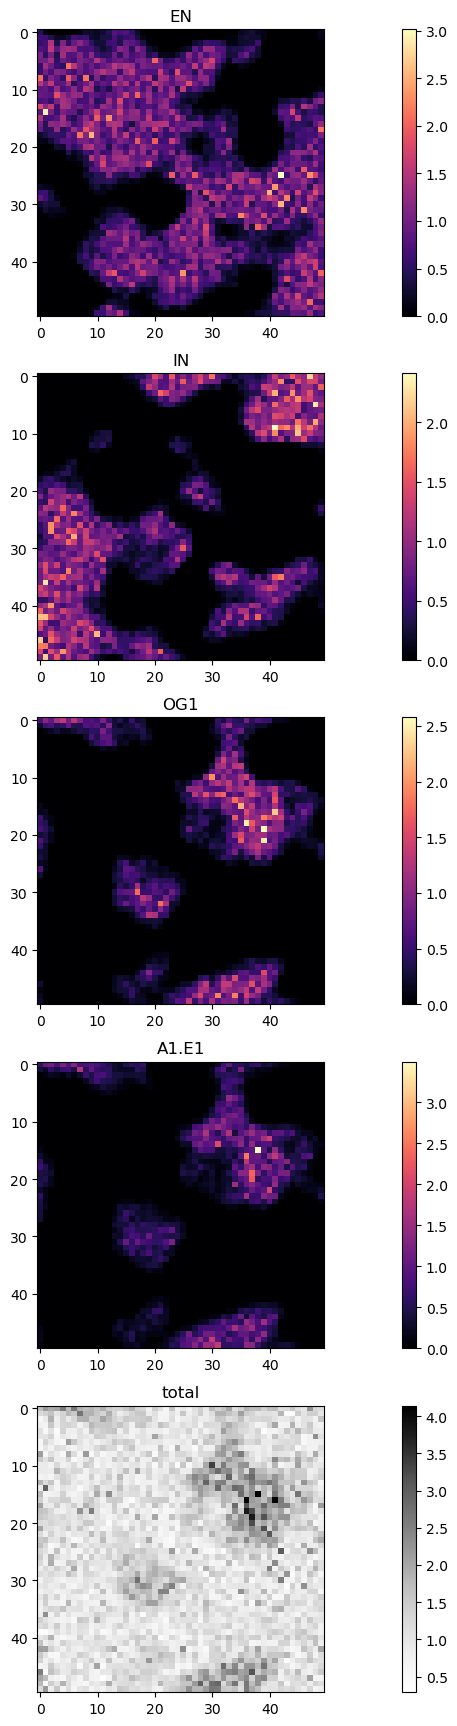

In [96]:
np.random.seed(seed)
cell_abundances = np.dot(abundances_df, cell_types2zones.T)
cell_abundances = cell_abundances * np.random.lognormal(0, 0.35, size=cell_abundances.shape)
cell_abundances_df = pd.DataFrame(cell_abundances, 
                             index=abundances_df.index,
                             columns=cell_types2zones.index
                            )
# Plots just the first experiment
plt.figure(figsize=(3*5+5, 3*10+5))
plot_spatial(cell_abundances_df.values[experiment_id==0,:], 
             n=n_locations, nrows=8, 
             names=cell_abundances_df.columns, vmax=None)
plt.show()


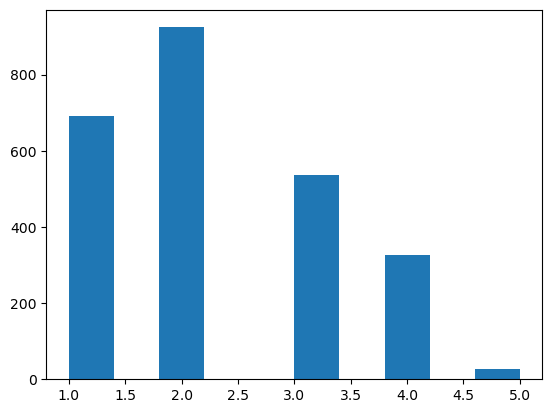

EN       2296.0
IN       1393.0
OG1       943.0
A1.E1     941.0
dtype: float64

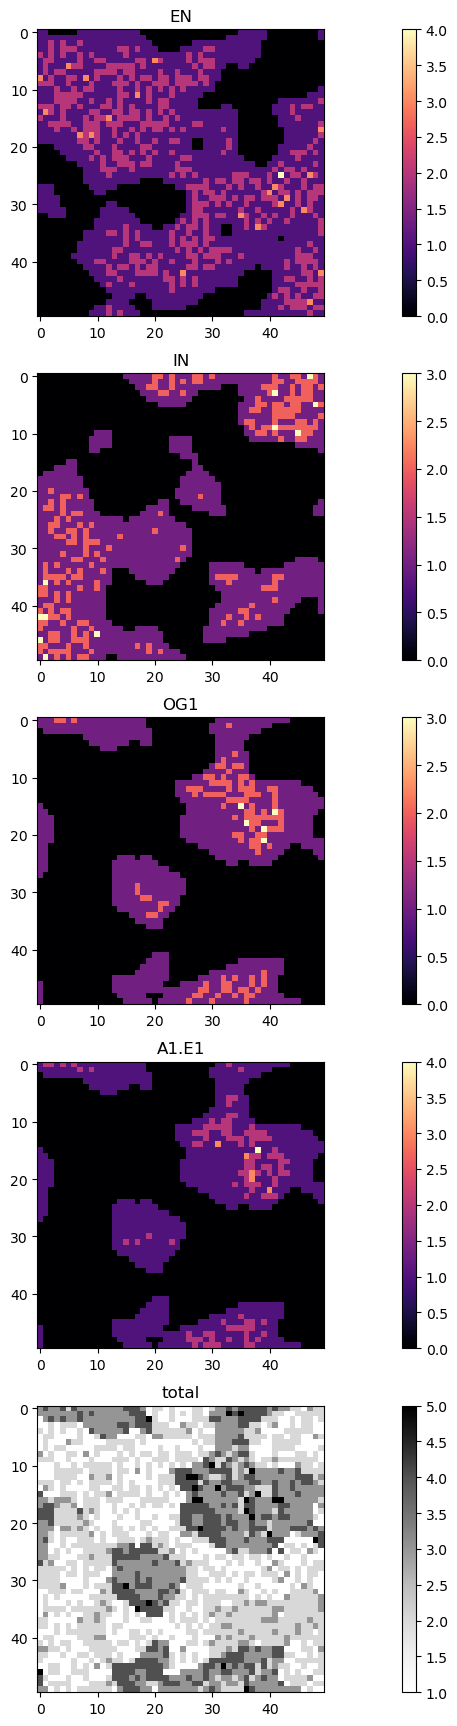

In [97]:
cell_count_df = np.ceil(cell_abundances_df)
plt.hist(cell_count_df.sum(1));
plt.show();

plt.figure(figsize=(3*5+5, 3*10+5))
plot_spatial(cell_count_df.values[experiment_id==0,:], 
             n=n_locations, nrows=8, 
             names=cell_count_df.columns, vmax=None)

cell_count_df.sum(0)

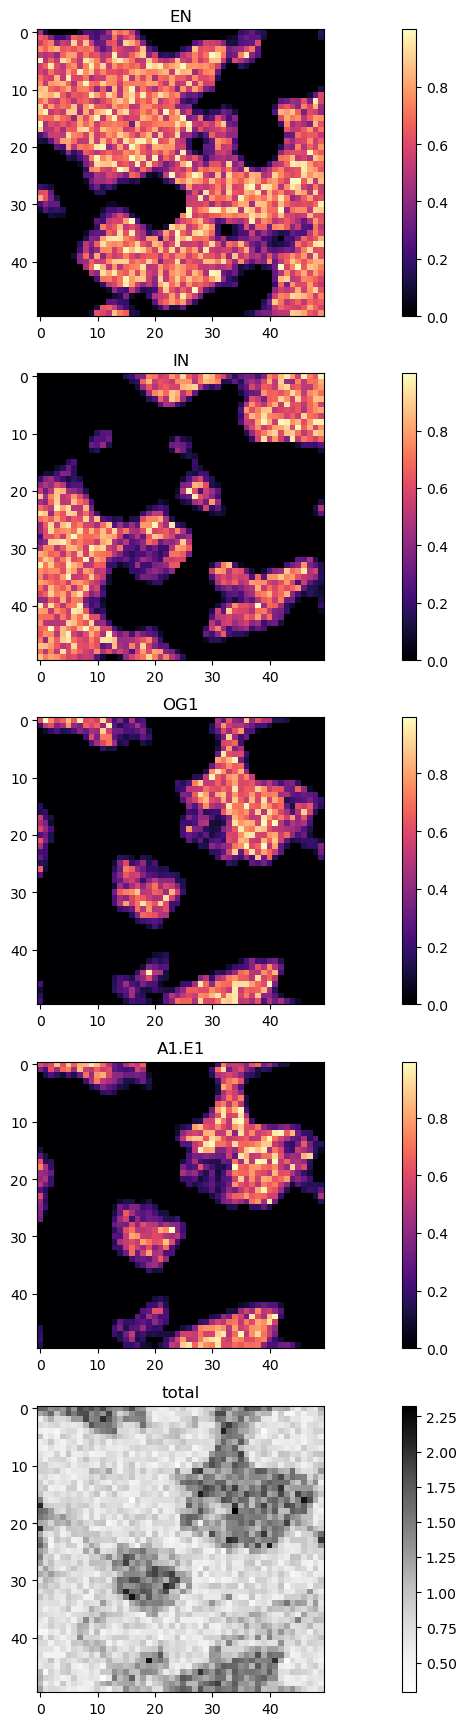

In [98]:
cell_capture_eff_df = cell_abundances_df / cell_count_df
cell_capture_eff_df[cell_capture_eff_df.isna()] = 0

plt.figure(figsize=(3*5+5, 3*10+5))
plot_spatial(cell_capture_eff_df.values[experiment_id==0,:], 
             n=n_locations, nrows=8, 
             names=cell_capture_eff_df.columns, vmax=None)

In [99]:
cell_count_df

,EN,IN,OG1,A1.E1
exper0_location_0,1.0,0.0,1.0,1.0
exper0_location_1,1.0,0.0,1.0,1.0
exper0_location_2,1.0,0.0,0.0,0.0
exper0_location_3,1.0,0.0,0.0,0.0
exper0_location_4,2.0,0.0,0.0,0.0
...,...,...,...,...
exper0_location_2495,2.0,0.0,0.0,0.0
exper0_location_2496,2.0,0.0,0.0,0.0
exper0_location_2497,1.0,0.0,0.0,0.0
exper0_location_2498,2.0,0.0,0.0,0.0


In [100]:
cell_capture_eff_df

,EN,IN,OG1,A1.E1
exper0_location_0,0.463422,0.0,0.616802,0.613592
exper0_location_1,0.654152,0.0,0.207667,0.348914
exper0_location_2,0.564188,0.0,0.000000,0.000000
exper0_location_3,0.762068,0.0,0.000000,0.000000
exper0_location_4,0.538138,0.0,0.000000,0.000000
...,...,...,...,...
exper0_location_2495,0.621135,0.0,0.000000,0.000000
exper0_location_2496,0.747942,0.0,0.000000,0.000000
exper0_location_2497,0.656548,0.0,0.000000,0.000000
exper0_location_2498,0.570214,0.0,0.000000,0.000000


In [101]:

# Save simulated spatial data to matrices. The data is in theree parts:
cell_count_df.to_csv(f'{sp_data_folder}cell_count_df_{date}.csv')
cell_capture_eff_df.to_csv(f'{sp_data_folder}cell_capture_eff_df_{date}.csv')
cell_abundances_df.to_csv(f'{sp_data_folder}cell_abundances_df_{date}.csv')

In [102]:
gp_bw = pd.DataFrame(np.concatenate((tissue_zones_l1_true, uniform_cell_types_l1_true)),
                     index=cell_types2zones.columns, columns=['GP_bandwidth'])
gp_bw.to_csv(f'{sp_data_folder}gp_bw_{date}.csv')
cell_types2zones['is_uniform'] = 0
cell_types2zones['is_uniform'][uniform_cell_types] = 1
cell_types2zones['is_high_density'] = 0
cell_types2zones['is_high_density'][high_density_cell_types] = 1
cell_types2zones.to_csv(f'{sp_data_folder}cell_types2zones_{date}.csv')

In [104]:
# Sample cell indices
np.random.seed(seed)

from scipy.sparse import csr_matrix

# create generation set
generation_rna = rna.copy()
# add index to each cell
generation_rna.obs['cell_ind'] = np.arange(rna.shape[0])

def sample_cell_indices(generation_rna, cell_count_df, cell_capture_eff_df):
    from scipy.sparse import csr_matrix
    locations2cells = np.zeros((cell_count_df.shape[0], generation_rna.shape[0]))
    for i, l in enumerate(cell_count_df.index):
        for j, ct in enumerate(cell_count_df.columns):
            cell_ind_all = generation_rna.obs['cell_ind']
            cell_ind_all = cell_ind_all[generation_rna.obs['broad_celltype'] == ct]
            cell_ind = np.random.choice(cell_ind_all, int(cell_count_df.loc[l, ct]), replace=False)
            locations2cells[i,cell_ind] = cell_capture_eff_df.loc[l, ct]

    return csr_matrix(locations2cells)
    
locations2cells = sample_cell_indices(generation_rna, cell_count_df, cell_capture_eff_df)

In [105]:
# Compute synthetic counts
synthetic_counts = locations2cells.dot(generation_rna.X)

# Create adata object
synth_adata = ad.AnnData(synthetic_counts)
synth_adata.obs_names = cell_count_df.index
synth_adata.var_names = generation_rna.var_names
synth_adata.obs[[f'cell_count_{ct}' for ct in cell_count_df.columns]] = cell_count_df
synth_adata.obs[[f'cell_abundances_{ct}' for ct in cell_abundances_df.columns]] = cell_abundances_df
synth_adata.obs[[f'cell_capture_eff_{ct}' for ct in cell_capture_eff_df.columns]] = cell_capture_eff_df
synth_adata.obsm['X_spatial'] = locations
synth_adata.uns['design'] = {'cell_types2zones': cell_types2zones,
                             'gp_bw': gp_bw}
from re import sub
synth_adata.obs['sample'] = [sub('_location.+$','',i) for i in synth_adata.obs_names]

synth_adata.shape

(2500, 21127)

In [106]:
# compute synthetic counts per cell type
for j, ct in enumerate(cell_count_df.columns):
    locations2cells_ct = sample_cell_indices(generation_rna, cell_count_df[[ct]], cell_capture_eff_df)
    synthetic_counts_ct = locations2cells_ct.dot(generation_rna.X)
    synth_adata.obs[f'UMI_count_{ct}'] = np.array(synthetic_counts_ct.sum(1)).flatten()

In [107]:
gene_level_df.index

Index(['Gnai3', 'Narf', 'Klf6', 'Scmh1', 'Cox5a', 'Wnt9a', 'Fer', 'Xpo6',
       'Tfe3', 'Axin2',
       ...
       'AC154782.1', 'AC118542.1', 'AC129328.1', 'AC166832.3', 'AC138306.1',
       'AC165953.2', 'AC110241.2', 'AC161607.1', 'Atp5o', '9030025P20Rik'],
      dtype='object', name='Gene', length=12809)

In [108]:
backup_gldf = gene_level_df
synth_backup = synth_adata

In [109]:
# Match genes and remove duplicates
common_genes = synth_adata.var_names.intersection(gene_level_df.index)

synth_adata = synth_adata[:,synth_adata.var.index.isin(common_genes)]
gene_level_df = gene_level_df[gene_level_df.index.isin(common_genes)]

synth_adata = synth_adata[:,~synth_adata.var.index.duplicated()]
gene_level_df = gene_level_df[~gene_level_df.index.duplicated()]

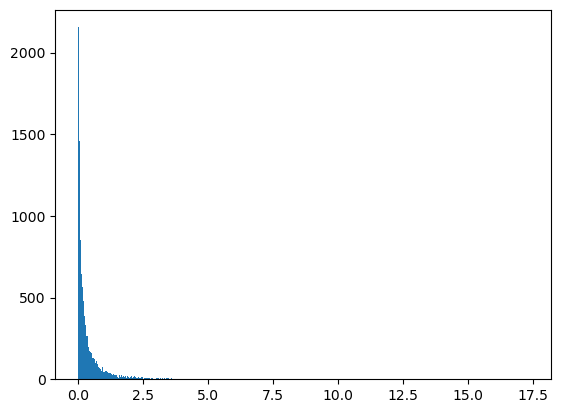

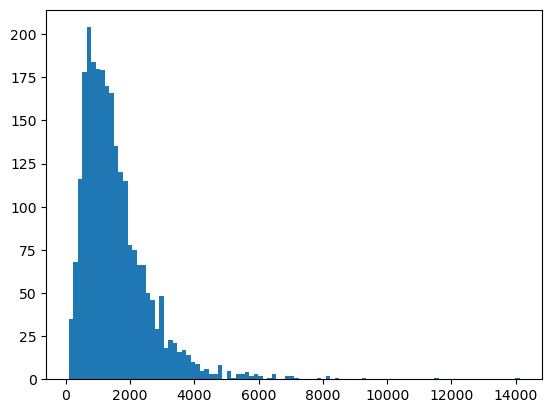

In [110]:
np.random.seed(seed)
# Use observed detection rates
synth_adata_obs_mg = synth_adata[:,synth_adata.var.index.isin(gene_level_df.index)].copy() #Updated
gene_level_df = gene_level_df[gene_level_df.index.isin(synth_adata_obs_mg.var.index)]
plt.hist(gene_level_df.values.flatten(), bins=500);
plt.show()

synth_adata_obs_mg.var['gene_level'] = gene_level_df.values.flatten()
synth_adata_obs_mg.X = synth_adata_obs_mg.X * gene_level_df.values.T

# Sample poisson integers
synth_adata_obs_mg.layers['expression_levels'] = synth_adata_obs_mg.X
synth_adata_obs_mg.X = csr_matrix(np.random.poisson(synth_adata_obs_mg.X))
gene_level_df.values.mean()

# save resulting anndata
synth_adata_obs_mg.write(f'{sp_data_folder}synth_adata_real_mg_{date}.h5ad')

plt.hist(np.array(synth_adata_obs_mg.X.sum(1)).flatten(), bins=100);
plt.show()

In [113]:
synth_adata_obs_mg

AnnData object with n_obs × n_vars = 2500 × 11777
    obs: 'cell_count_EN', 'cell_count_IN', 'cell_count_OG1', 'cell_count_A1.E1', 'cell_abundances_EN', 'cell_abundances_IN', 'cell_abundances_OG1', 'cell_abundances_A1.E1', 'cell_capture_eff_EN', 'cell_capture_eff_IN', 'cell_capture_eff_OG1', 'cell_capture_eff_A1.E1', 'sample', 'UMI_count_EN', 'UMI_count_IN', 'UMI_count_OG1', 'UMI_count_A1.E1'
    var: 'gene_level'
    uns: 'design'
    obsm: 'X_spatial'
    layers: 'expression_levels'

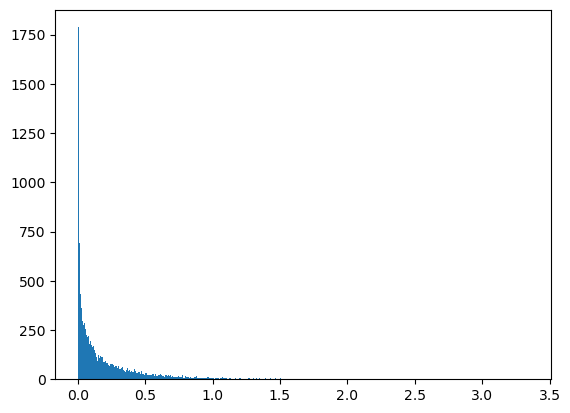

ValueError: dimension mismatch

In [114]:
np.random.seed(seed)
# Sample detection rates
gene_level = np.random.gamma(shape=posterior.posterior['gene_level_alpha_hyp'].mean(), 
                             scale=1/posterior.posterior['gene_level_beta_hyp'].mean(), 
                             size=(1, synth_adata.shape[1])) / 2
plt.hist(gene_level.flatten(), bins=500);
plt.show()

synth_adata.var['gene_level'] = gene_level.flatten()
synth_adata.X = synth_adata.X * gene_level

# Sample poisson integers
synth_adata.layers['expression_levels'] = synth_adata.X
synth_adata.X = np.random.poisson(synth_adata.X)
synth_adata.X = csr_matrix(synth_adata.X)
gene_level.mean()

# save resulting anndata
synth_adata.write(f'{sp_data_folder}synth_adata_random_mg_{date}.h5ad')

plt.hist(np.array(synth_adata.X.sum(1)).flatten(), bins=100);
plt.show()

In [115]:
np.random.seed(seed)

synth_adata_contam = synth_adata.copy()

# sample contamination
contamination_average = synth_adata.X.mean(0)

mu_contamination = 0.03
mean_var_ratio=150
per_experiment_proportion = np.random.gamma(mu_contamination * mean_var_ratio, 
                                            1/mean_var_ratio, 
                                            size=(n_experiments, 1))

average_contamination = per_experiment_proportion * contamination_average
cell2sample_df = pd.get_dummies(synth_adata.obs['sample'])
per_loc_average_contamination = np.dot(cell2sample_df.values, average_contamination)

# add contamination counts
contamination = csr_matrix(np.random.poisson(per_loc_average_contamination))
synth_adata_contam.layers['contamination'] = contamination
synth_adata_contam.X = synth_adata_contam.X + contamination

# save resulting anndata
synth_adata_contam.write(f'{sp_data_folder}synth_adata_contamination_{date}.h5ad')

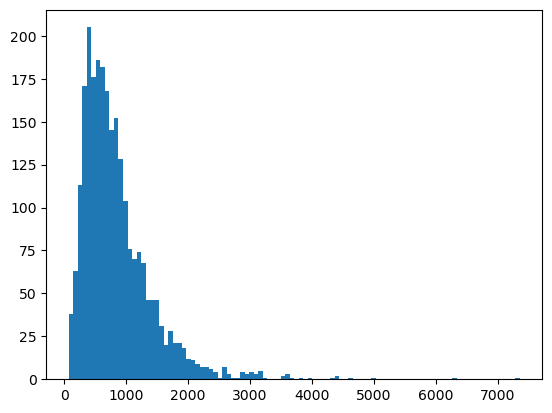

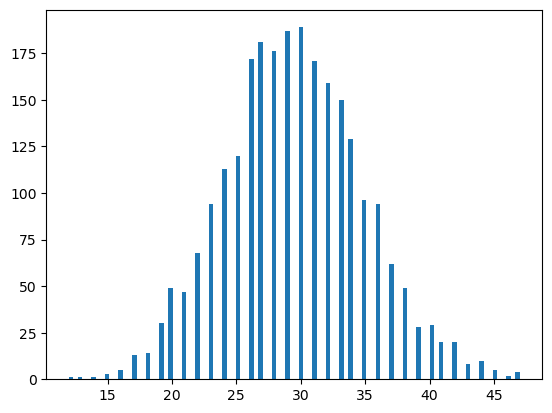

In [116]:
plt.hist(np.array(synth_adata_contam.X.sum(1)).flatten(), bins=100);
plt.show();
plt.hist(np.array(synth_adata_contam.layers['contamination'].sum(1)).flatten(), bins=100);
plt.show();

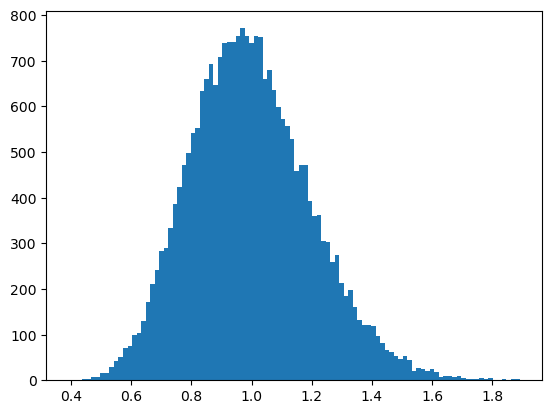

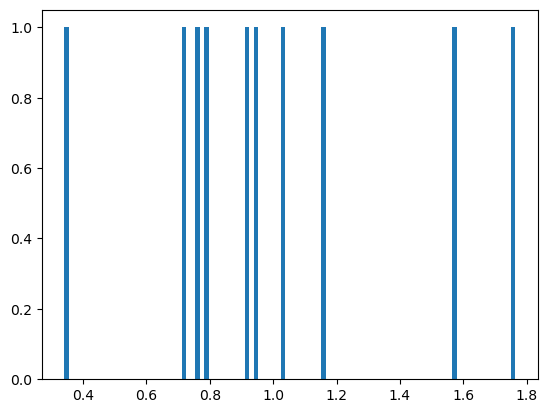

In [37]:
np.random.seed(seed)

synth_adata_contam_depth = synth_adata.copy()

# sample contamination
contamination_average = synth_adata.X.mean(0)

mu_contamination = 0.03
mean_var_ratio=150
per_experiment_proportion = np.random.gamma(mu_contamination * mean_var_ratio, 
                                            1/mean_var_ratio, 
                                            size=(n_experiments, 1))

average_contamination = per_experiment_proportion * contamination_average
cell2sample_df = pd.get_dummies(synth_adata.obs['sample'])
per_loc_average_contamination = np.dot(cell2sample_df.values, average_contamination)

# samples per-location variability in sequencing depth
mu_depth = 1
mean_var_ratio=25
per_location_depth = np.random.gamma(mu_depth * mean_var_ratio, 
                                            1/mean_var_ratio, 
                                            size=(synth_adata.shape[0], 1))
plt.hist(np.array(per_location_depth).flatten(), bins=100);
plt.show()

# sample per-experiment variability in sequencing depth
mu_depth = 1
mean_var_ratio=5
per_experiment_depth = np.random.gamma(mu_depth * mean_var_ratio, 
                                            1/mean_var_ratio, 
                                            size=(n_experiments, 1))
plt.hist(np.array(per_experiment_depth).flatten(), bins=100);
plt.show()

# generate total sequencing depth effect
per_location_depth_total = per_location_depth * np.dot(cell2sample_df.values, per_experiment_depth)
synth_adata_contam_depth.obs['per_location_depth_total'] = np.array(per_location_depth_total).flatten()
synth_adata_contam_depth.obs['per_location_depth'] = np.array(per_location_depth).flatten()
synth_adata_contam_depth.obs['per_experiment_depth'] = np.array(np.dot(cell2sample_df.values,
                                                                       per_experiment_depth)).flatten()

# add sequencing depth effect
synth_adata_contam_depth.layers['expression_levels_depth'] \
= synth_adata_contam_depth.layers['expression_levels'] * per_location_depth_total
synth_adata_contam_depth.X = csr_matrix(np.random.poisson(synth_adata_contam_depth.layers['expression_levels_depth']))

# add contamination counts
contamination = csr_matrix(np.random.poisson(np.array(per_loc_average_contamination) * per_location_depth_total))
synth_adata_contam_depth.layers['contamination'] = contamination
synth_adata_contam_depth.X = synth_adata_contam_depth.X + contamination

# save resulting anndata
synth_adata_contam_depth.write(f'{sp_data_folder}synth_adata_contamination_depth_{date}.h5ad')

In [117]:
plt.hist(np.array(synth_adata_contam_depth.X.sum(1)).flatten(), bins=100);
plt.show();
plt.hist(np.array(synth_adata_contam_depth.layers['contamination'].sum(1)).flatten(), bins=100);
plt.show();

NameError: name 'synth_adata_contam_depth' is not defined

In [118]:
plt.hist(np.array(synth_adata_contam_depth[synth_adata_contam_depth.obs['sample'] == 'exper1',:].X.sum(1)).flatten(), bins=100);
plt.show();
plt.hist(np.array(synth_adata_contam_depth[synth_adata_contam_depth.obs['sample'] == 'exper1',:].layers['contamination'].sum(1)).flatten(), bins=100);
plt.show();

NameError: name 'synth_adata_contam_depth' is not defined